# Implementing the impact of the radial integral constraint on the (pseudo-) power spectrum computation

Let's try to include radial integral constraints.

In [1]:
from pathlib import Path
from functools import partial
#import os
#os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.' # NOTE: jax preallocates GPU (default 75%)

import numpy as np
import jax
from jax import numpy as jnp
from jax import random

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5, 4)

from jaxpower import (ParticleField, BinMesh2SpectrumPoles, compute_mesh2_spectrum, compute_mesh2_spectrum_mean,
compute_normalization, generate_anisotropic_gaussian_mesh, MeshAttrs, utils)
from lsstypes import ObservableTree, ObservableLeaf, WindowMatrix

plots_dir = Path('_plots')
ext = 'png'

In [2]:
# To highlight the effect of the window convolution,
# we generate a power spectrum with high frequency BAO

from cosmoprimo.fiducial import DESI
cosmo = DESI(engine='eisenstein_hu_nowiggle')
pk = cosmo.get_fourier().pk_interpolator().to_1d(z=1.)

mattrs = MeshAttrs(boxsize=2000., meshsize=128, boxcenter=1200.)
edgesin = np.arange(0., mattrs.knyq.max() + 0.001, 0.001)
edgesin = jnp.column_stack([edgesin[:-1], edgesin[1:]])

kin = jnp.mean(edgesin, axis=-1)
pkin = pk(kin) * (1. + 0.2 * np.sin(kin / 0.006))
ells = (0, 2, 4)

f, b = 0.8, 1.5
pkb = b**2 * pkin
beta = f / b
poles = [(1. + 2. / 3. * beta + 1. / 5. * beta ** 2) * pkb,
         0.9 * (4. / 3. * beta + 4. / 7. * beta ** 2) * pkb,
          8. / 35 * beta ** 2 * pkb]
poles = jnp.array(poles)

theory = ObservableTree([ObservableLeaf(k=kin, k_edges=edgesin, value=pole, coords=['k']) for pole in poles], ells=ells)

bin = BinMesh2SpectrumPoles(mattrs, edges={'step': 0.005}, ells=ells)


def gaussian_survey(mattrs, size=int(1e8), seed=random.key(42), scale=0.2, paint=False):
    # Generate Gaussian-distributed positions
    positions = scale * random.normal(seed, shape=(size, 3))
    bscale = 2. * scale  # cut at 2 sigmas
    mask = jnp.all((positions > -bscale) & (positions < bscale), axis=-1)
    positions = positions * mattrs.boxsize + mattrs.boxcenter
    toret = ParticleField(positions, weights=1. * mask, attrs=mattrs)
    if paint: toret = toret.paint(resampler='cic', interlacing=0, compensate=False)
    return toret


def apply_selection(mesh, selection, ic=None):
    # Selection function
    mesh = mesh * selection
    if ic == 'radial':
        mattrs = mesh.attrs
        dmin = np.min(mattrs.boxcenter - mattrs.boxsize / 2.)
        dmax = (1. + 1e-9) * jnp.sqrt(jnp.sum((mattrs.boxcenter + mattrs.boxsize / 2.)**2))
        edges = jnp.linspace(dmin, dmax, 1000)
        rnorm = jnp.sqrt(sum(xx**2 for xx in mattrs.rcoords(sparse=True)))
        ibin = jnp.digitize(rnorm, edges, right=False)
        bw = jnp.bincount(ibin.ravel(), weights=mesh.ravel(), length=len(edges) + 1)
        b = jnp.bincount(ibin.ravel(), weights=selection.ravel(), length=len(edges) + 1)
        # Integral constraint
        bw = bw / jnp.where(b == 0., 1., b)  # (integral of W * delta) / (integral of W)
        mesh -= bw[ibin].reshape(selection.shape) * selection
    return mesh

def mock_survey(theory, selection, unitary_amplitude=False, los='local', ic=None, seed=random.key(42)):
    # Generate Gaussian field
    mattrs = selection.attrs
    mesh = generate_anisotropic_gaussian_mesh(mattrs, theory, unitary_amplitude=unitary_amplitude, los=los, seed=seed)
    # Multiply Gaussian field with survey selection function, then compute power spectrum
    norm = compute_normalization(selection, selection, bin=bin)
    mesh = apply_selection(mesh, selection, ic=ic)
    return compute_mesh2_spectrum(mesh, bin=bin, los={'local': 'firstpoint'}.get(los, los)).clone(norm=norm)


/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250526-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


In [3]:
gaussian_survey = jax.jit(gaussian_survey, static_argnames=['size', 'paint'])
selection = gaussian_survey(mattrs, paint=True)

get_spectrum = lambda theory, **kwargs: mock_survey(theory, selection, **kwargs)
get_spectrum = jax.jit(get_spectrum, static_argnames=['ic'])

from tqdm import trange
spectra, spectra_ic = [], []
nreal = 1000
with trange(nreal) as t:
    for imock in t:
        seed = random.key(2 * imock + 1)
        spectra.append(get_spectrum(theory, seed=seed, ic=None))
        spectra_ic.append(get_spectrum(theory, seed=seed, ic='radial'))

100%|██████████| 1000/1000 [00:53<00:00, 18.62it/s]


/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250526-1.0.0/conda/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250526-1.0.0/conda/lib/python3.10/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250526-1.0.0/conda/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


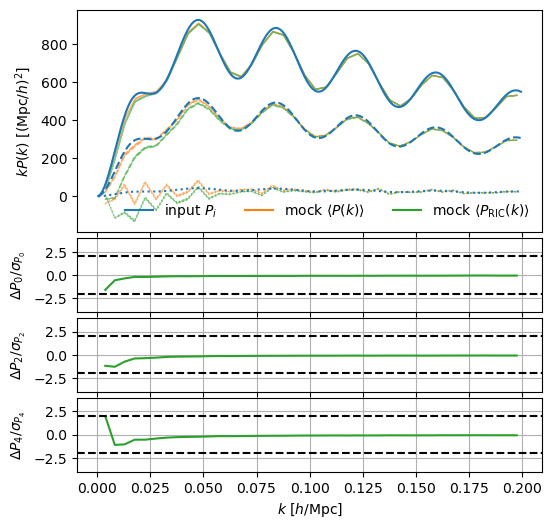

In [4]:
import lsstypes as types
mean, cov = types.mean(spectra), types.cov(spectra).clone(attrs={'nreal': len(spectra)})
mean_ic, cov_ic = types.mean(spectra_ic), types.cov(spectra_ic).clone(attrs={'nreal': len(spectra_ic)})

ells = mean.ells
height_ratios = [max(len(ells), 3)] + [1] * len(ells)
figsize = (6, 1. * sum(height_ratios))
fig, lax = plt.subplots(len(height_ratios), sharex=True, sharey=False, gridspec_kw={'height_ratios': height_ratios}, figsize=figsize, squeeze=True)
fig.subplots_adjust(hspace=0.05)

ax = lax[0]
linestyles = ['-', '--', ':']
colors = ['C0', 'C1', 'C2']
labels = ['input $P_i$', r'mock $\langle P(k) \rangle$', r'mock $\langle P_\mathrm{RIC}(k) \rangle$']
for color, label in zip(colors, labels):
    ax.plot([], [], color=color, linestyle='-', label=label)
for ill, ell in enumerate(ells):
    linestyle = linestyles[ill]
    pole = mean.get(ell)
    pole_in = theory.get(ell).select(k=(0., pole.edges('k').max()))
    ax.plot(pole_in.coords('k'), pole_in.coords('k') * pole_in.value(), linestyle=linestyle, color=colors[0])
    kw = dict(lw=1., alpha=0.5)
    std = cov.at.observable.get(ell).std().real / cov.attrs['nreal']**0.5
    ax.fill_between(pole.coords('k'), pole.coords('k') * (pole.value() - std), pole.coords('k') * (pole.value() + std), linestyle=linestyle, color=colors[1], **kw)
    pole = mean_ic.get(ell)
    std = cov_ic.at.observable.get(ell).std().real / cov_ic.attrs['nreal']**0.5
    ax.fill_between(pole.coords('k'), pole.coords('k') * (pole.value() - std), pole.coords('k') * (pole.value() + std), linestyle=linestyle, color=colors[2], **kw)
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False, ncol=3)
for ill, ell in enumerate(ells):
    ax = lax[ill + 1]
    pole, pole_ic = mean.get(ell), mean_ic.get(ell)
    std = cov_ic.at.observable.get(ell).std().real
    ax.plot(pole.coords('k'), (pole_ic.value() - pole.value()) / std, color=colors[2])
    ax.set_ylim(-3., 3.)
    ax.set_ylim(-4, 4)
    for offset in [-2., 2.]: ax.axhline(offset, color='k', linestyle='--')
    ax.grid(True)
    ax.set_ylabel(r'$\Delta P_{{{0:d}}} / \sigma_{{ P_{{{0:d}}} }}$'.format(ell))
lax[-1].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
utils.savefig(plots_dir / f'mocks_ric.{ext}')
plt.show()

In [5]:
def get_window_slab_fwd(func, theory, nreal=10, batch_size=1, **kwargs):
    # Forward mode
    with_seed = nreal is not None
    nreal = 1 if nreal is None else nreal
    windows = [None for i in range(nreal)]
    observable = func(theory, **kwargs)
    observable = observable.clone(value=0. * observable.value())
    value = theory.value()
    zeros = jnp.zeros_like(value)
    get_window = lambda s, **kwargs: jax.vmap(lambda s: jax.jvp(lambda value: jnp.concatenate(func(theory.clone(value=value), **kwargs).value(concatenate=False)).real,
                                                                (value,), (s,))[1])(s)
    get_window = jax.jit(get_window)
    nsplits = (theory.size + batch_size - 1) // batch_size
    from tqdm import tqdm
    for isplit in tqdm(range(nsplits)):
        islice = isplit * zeros.size // nsplits, (isplit + 1) * zeros.size // nsplits
        ivalue = jnp.array([zeros.at[ii].set(1.) for ii in range(*islice)])
        args = (ivalue,)
        kw = dict(kwargs)
        for imock in range(nreal):
            if with_seed: kw.update(seed=random.key(2 * imock + 3))
            spectrum = get_window(*args, **kw).T
            if windows[imock] is None:
                windows[imock] = np.zeros((spectrum.shape[0], theory.size))
            windows[imock][..., slice(*islice)] = spectrum
    windows = [WindowMatrix(value=window, theory=theory, observable=observable) for window in windows]
    window = WindowMatrix(value=np.mean([window.value() for window in windows], axis=0), theory=theory, observable=observable)
    if with_seed:
        return window, windows
    return window

In [6]:
window_brute_force, windows_brute_force = get_window_slab_fwd(lambda theory, **kwargs: mock_survey(theory, selection, ic='radial', unitary_amplitude=True, **kwargs),
                                          theory, nreal=25, batch_size=20)



100%|██████████| 31/31 [02:41<00:00,  5.21s/it]


In [7]:
def mock_survey_diff(theory, selection, unitary_amplitude=True, los='local', seed=random.key(42)):
    # Generate Gaussian field
    mattrs = selection.attrs
    mesh = generate_anisotropic_gaussian_mesh(mattrs, theory, unitary_amplitude=unitary_amplitude, los=los, seed=seed)

    # Multiply Gaussian field with survey selection function, then compute power spectrum
    norm = compute_normalization(selection, selection, bin=bin)
    spectra = [compute_mesh2_spectrum(apply_selection(mesh, selection, ic=ic), bin=bin, los={'local': 'firstpoint'}.get(los, los)).clone(norm=norm)
               for ic in ['radial', None]]
    return types.tree_map(lambda poles: pole.clone(value=poles[0].value() - poles[1].value()), spectra)

window_diff, windows_diff = get_window_slab_fwd(lambda theory, **kwargs: mock_survey_diff(theory, selection, unitary_amplitude=True, **kwargs),
                                                theory, nreal=25, batch_size=20)

100%|██████████| 31/31 [04:34<00:00,  8.86s/it]


In [8]:
def mean_survey(theory, selection, los='local'):
    # Multiply Gaussian field with survey selection function, then compute power spectrum
    norm = compute_normalization(selection, selection, bin=bin)
    if los == 'local': theory = (theory, los)  # local line-of-sight
    return compute_mesh2_spectrum_mean(selection, bin=bin, theory=theory, los={'local': 'firstpoint'}.get(los, los)).clone(norm=norm)

mean = mean_survey(theory, selection)

window_mean = get_window_slab_fwd(lambda theory, **kwargs: mean_survey(theory, selection, **kwargs), theory, nreal=None, batch_size=10)

100%|██████████| 61/61 [02:36<00:00,  2.57s/it] 


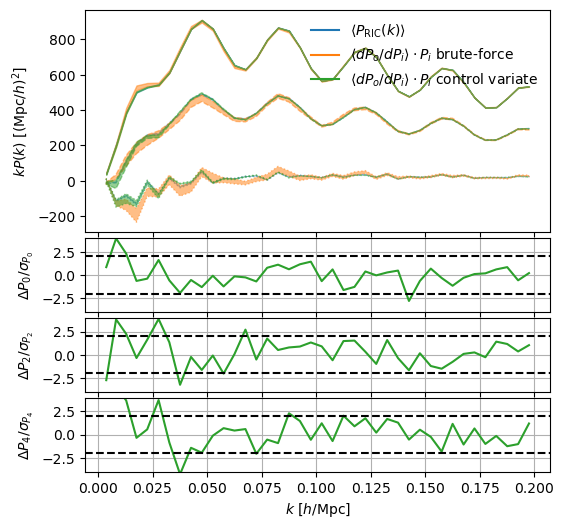

In [9]:
spectra_cv = [window_mean.clone(value=window_mean.value() + wd.value()).dot(theory, return_type=None, zpt=False) for wd in windows_diff]
mean_cv, cov_cv = types.mean(spectra_cv), types.cov(spectra_cv).clone(attrs={'nreal': len(spectra_cv)})

spectra_brute_force = [w.dot(theory, return_type=None, zpt=False) for w in windows_brute_force]
mean_brute_force, cov_brute_force = types.mean(spectra_brute_force), types.cov(spectra_brute_force).clone(attrs={'nreal': len(spectra_brute_force)})

ells = mean.ells
height_ratios = [max(len(ells), 3)] + [1] * len(ells)
figsize = (6, 1. * sum(height_ratios))
fig, lax = plt.subplots(len(height_ratios), sharex=True, sharey=False, gridspec_kw={'height_ratios': height_ratios}, figsize=figsize, squeeze=True)
fig.subplots_adjust(hspace=0.05)
ax = lax[0]
linestyles = ['-', '--', ':']
colors = ['C0', 'C1', 'C2']
labels = [r'$\langle P_\mathrm{RIC}(k) \rangle$',
          r'$\langle dP_o/dP_i \rangle \cdot P_i$ brute-force',
          r'$\langle dP_o/dP_i \rangle \cdot P_i$ control variate']
for color, label in zip(colors, labels):
    ax.plot([], [], color=color, linestyle='-', label=label)
for ill, ell in enumerate(ells):
    linestyle = linestyles[ill]
    kw = dict(lw=1., alpha=0.5)
    pole = mean_ic.get(ell)
    std = cov_ic.at.observable.get(ell).std().real / cov_ic.attrs['nreal']**0.5
    ax.fill_between(pole.coords('k'), pole.coords('k') * (pole.value() - std), pole.coords('k') * (pole.value() + std), linestyle=linestyle, color=colors[0], **kw)
    pole = mean_brute_force.get(ell)
    std = cov_brute_force.at.observable.get(ell).std().real / cov_brute_force.attrs['nreal']**0.5
    ax.fill_between(pole.coords('k'), pole.coords('k') * (pole.value() - std), pole.coords('k') * (pole.value() + std), linestyle=linestyle, color=colors[1], **kw)
    pole = mean_cv.get(ell)
    std = cov_cv.at.observable.get(ell).std().real / cov_cv.attrs['nreal']**0.5
    ax.fill_between(pole.coords('k'), pole.coords('k') * (pole.value() - std), pole.coords('k') * (pole.value() + std), linestyle=linestyle, color=colors[2], **kw)
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False)
for ill, ell in enumerate(ells):
    ax = lax[ill + 1]
    pole_ic = mean_ic.get(ell)
    pole_cv = mean_cv.get(ell)
    std = cov_ic.at.observable.get(ell).std().real / cov_ic.attrs['nreal']**0.5
    ax.plot(pole_cv.coords('k'), (pole_ic.value() - pole_cv.value()) / std, color=colors[2])
    ax.set_ylim(-3., 3.)
    ax.set_ylim(-4, 4)
    for offset in [-2., 2.]: ax.axhline(offset, color='k', linestyle='--')
    ax.grid(True)
    ax.set_ylabel(r'$\Delta P_{{{0:d}}} / \sigma_{{ P_{{{0:d}}} }}$'.format(ell))
lax[-1].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
utils.savefig(plots_dir / f'mocks_ric_window.{ext}')
plt.show()